In [1]:
import pandas as pd
import pvlib
from pvlib import clearsky
import matplotlib.pyplot as plt
import numpy as np


pressure=100606.29526352999



<Figure size 640x480 with 0 Axes>

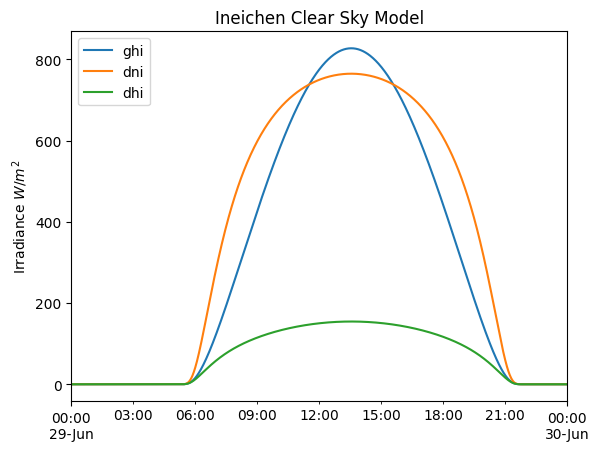

In [2]:
latitude, longitude, tz, altitude, name = 51.5751116, 7.6547815, 'Europe/Berlin', 60, 'Kamen'

times = pd.date_range(start='2024-06-29', end='2024-06-30', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_zenith = solpos['apparent_zenith']

airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)

pressure = pvlib.atmosphere.alt2pres(altitude)

airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)

print(f"""
{pressure=}
""")

# an input is a pandas Series, so solis is a DataFrame

ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)

plt.figure();

ax = ineichen.plot()

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Ineichen Clear Sky Model');

ax.legend(loc=2);

<Axes: >

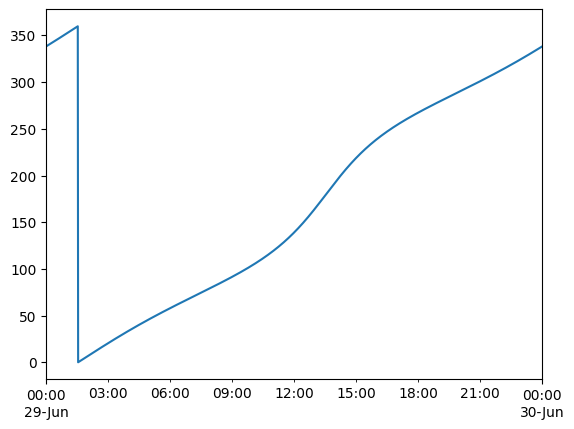

In [3]:
solpos["azimuth"].plot()

<Axes: >

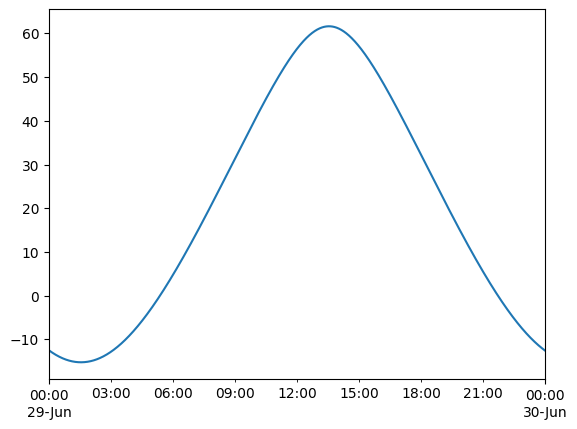

In [4]:
solpos["elevation"].plot()

In [5]:
solpos.loc["2024-06-29 13:50"]

apparent_zenith        28.573155
zenith                 28.582322
apparent_elevation     61.426845
elevation              61.417678
azimuth               188.199367
equation_of_time       -3.589666
Name: 2024-06-29 13:50:00+02:00, dtype: float64

In [6]:
def direction_vec(elevation, azimuth):
    se = np.sin(np.radians(elevation))
    ce = np.cos(np.radians(elevation))
    sa = np.sin(np.radians(azimuth))
    ca = np.cos(np.radians(azimuth))
    return np.array([sa * ce, ca * ce, se])

In [7]:
solpos.loc["2024-06-29 13:55", ["elevation", "azimuth"]].values

array([ 61.29072355, 190.58149116])

In [8]:
direction_vec(solpos["elevation"], solpos["azimuth"])

array([[-0.3622551 , -0.35856697, -0.35487201, ..., -0.37050341,
        -0.36682894, -0.36314748],
       [ 0.90667415,  0.90790575,  0.90912474, ...,  0.90362643,
         0.90488623,  0.90613346],
       [-0.21613246, -0.21711029, -0.21807812, ..., -0.21491042,
        -0.21591072, -0.21690104]])

In [9]:
def irradiation_factor(sun_vec, window_vec):
    return np.max([sun_vec @ window_vec, 0])

In [10]:
sun_dir = direction_vec(*solpos.loc["2024-06-29 13:55", ["elevation", "azimuth"]].values)
window_dir = direction_vec(0, 226)
print(f"{sun_dir=}\n{window_dir=}")

sun_dir=array([-0.08821135, -0.47219676,  0.8770684 ])
window_dir=array([-0.7193398 , -0.69465837,  0.        ])


In [11]:
irradiation_factor(sun_dir, window_dir)

np.float64(0.39146936359490975)

In [12]:
top_window_dir = direction_vec(74, 226)
top_window_dir

array([-0.19827692, -0.1914738 ,  0.9612617 ])

In [13]:
direction_vec(*solpos[["elevation", "azimuth"]].values.T)

array([[-0.3622551 , -0.35856697, -0.35487201, ..., -0.37050341,
        -0.36682894, -0.36314748],
       [ 0.90667415,  0.90790575,  0.90912474, ...,  0.90362643,
         0.90488623,  0.90613346],
       [-0.21613246, -0.21711029, -0.21807812, ..., -0.21491042,
        -0.21591072, -0.21690104]])

In [14]:
irradiation_factor(direction_vec(*solpos.loc["2024-06-29 14:22", ["elevation", "azimuth"]].values), top_window_dir)

np.float64(0.9597033751977333)

<Axes: >

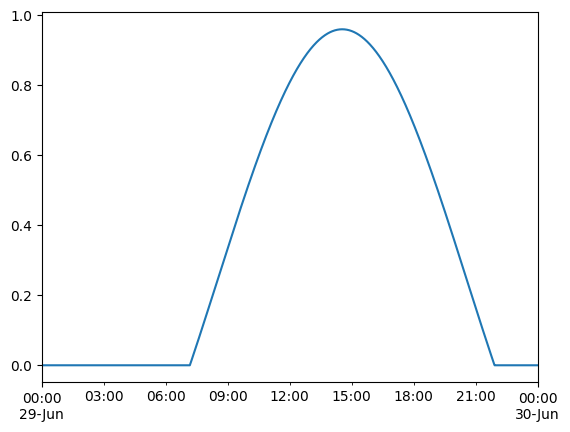

In [15]:
solpos[["elevation", "azimuth"]].apply(lambda row: irradiation_factor(direction_vec(*row), top_window_dir), axis=1).plot()

In [16]:
df_window_factors = solpos.copy()

In [17]:
df_window_factors["wintergarten_top"] = solpos[["elevation", "azimuth"]].apply(
    lambda row: irradiation_factor(
        direction_vec(*row),
        direction_vec(74, 226)
    ),
    axis=1,
)
df_window_factors["wintergarten_south"] = solpos[["elevation", "azimuth"]].apply(
    lambda row: irradiation_factor(
        direction_vec(*row),
        direction_vec(0, 226)
    ),
    axis=1,
)
df_window_factors["wintergarten_west"] = solpos[["elevation", "azimuth"]].apply(
    lambda row: irradiation_factor(
        direction_vec(*row),
        direction_vec(0, 316)
    ),
    axis=1,
)

df_window_factors["wintergarten_diagonal"] = solpos[["elevation", "azimuth"]].apply(
    lambda row: irradiation_factor(
        direction_vec(*row),
        direction_vec(0, 271)
    ),
    axis=1,
)

<Axes: >

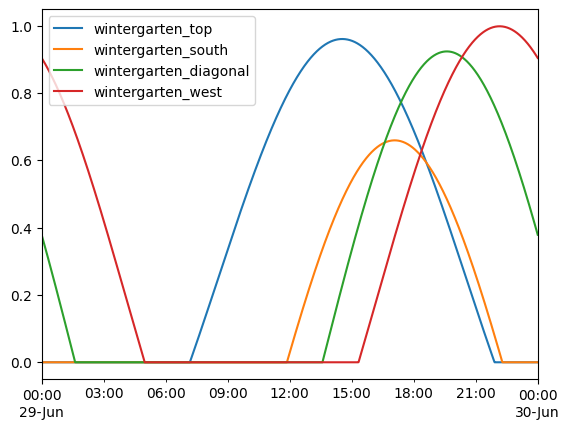

In [18]:
df_window_factors[["wintergarten_top", "wintergarten_south", "wintergarten_diagonal", "wintergarten_west"]].plot()

In [19]:
df_combined = df_window_factors.join(ineichen)

In [20]:
df_combined["top_curve"] = df_combined.eval("17 * (wintergarten_top * dni + dhi)")
df_combined["south_curve"] = df_combined.eval("12 * (wintergarten_south * dni + dhi)")
df_combined["diagonal_curve"] = df_combined.eval("2.5 * (wintergarten_diagonal * dni + dhi)")
df_combined["west_curve"] = df_combined.eval("6 * (wintergarten_west * dni + dhi)")

<Axes: >

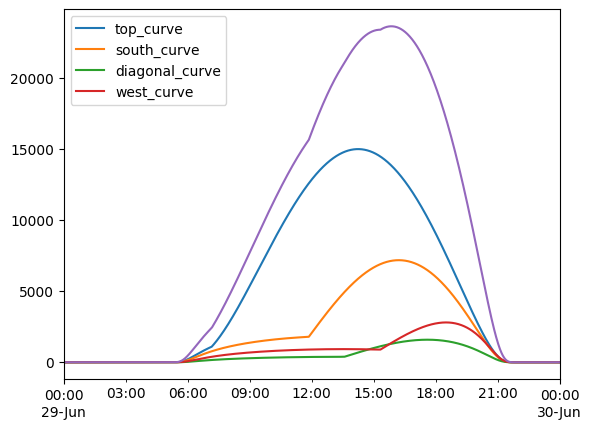

In [21]:
df_combined[["top_curve", "south_curve", "diagonal_curve", "west_curve"]].plot()
df_combined[["top_curve", "south_curve", "diagonal_curve", "west_curve"]].sum(axis=1).plot()

In [22]:
df_combined = df_window_factors.join(ineichen)

In [23]:
df_combined["top_curve"] = df_combined.eval("17 * (wintergarten_top * dni + dhi)")
df_combined["south_curve"] = df_combined.eval("12 * (wintergarten_south * dni + dhi)")
df_combined["diagonal_curve"] = df_combined.eval("2.5 * (wintergarten_diagonal * dni + dhi)")
df_combined["west_curve"] = df_combined.eval("6 * (wintergarten_west * dni + dhi)")

In [24]:
df_combined_opt = df_window_factors.join(ineichen)

In [25]:
df_combined_opt["top_curve"] = df_combined_opt.eval("17 * (wintergarten_top * dni + dhi) * 0.1")
df_combined_opt["south_curve"] = df_combined_opt.eval("12 * (wintergarten_south * dni + dhi) * 0.1")
df_combined_opt["diagonal_curve"] = df_combined_opt.eval("2.5 * (wintergarten_diagonal * dni + dhi) * 0.1")
df_combined_opt["west_curve"] = df_combined_opt.eval("6 * (wintergarten_west * dni + dhi) * 0.1")

<Axes: >

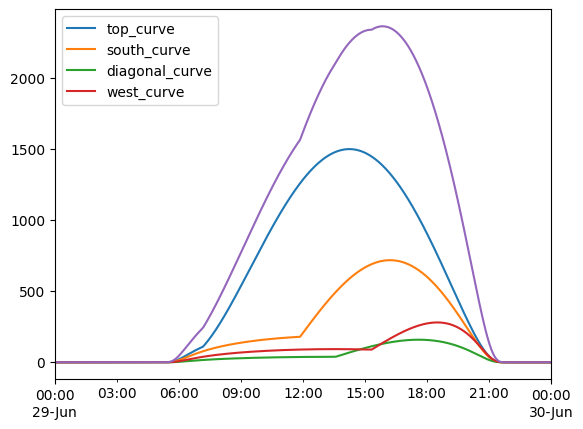

In [26]:
df_combined_opt[["top_curve", "south_curve", "diagonal_curve", "west_curve"]].plot()
df_combined_opt[["top_curve", "south_curve", "diagonal_curve", "west_curve"]].sum(axis=1).plot()

In [30]:
df_combined_opt

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,wintergarten_top,wintergarten_south,wintergarten_west,wintergarten_diagonal,ghi,dni,dhi,top_curve,south_curve,diagonal_curve,west_curve
2024-06-29 00:00:00+02:00,102.481975,102.481975,-12.481975,-12.481975,338.221178,-3.474473,0.0,0.0,0.903850,0.378024,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 00:01:00+02:00,102.539363,102.539363,-12.539363,-12.539363,338.449027,-3.474612,0.0,0.0,0.902174,0.374357,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 00:02:00+02:00,102.596176,102.596176,-12.596176,-12.596176,338.677077,-3.474751,0.0,0.0,0.900484,0.370684,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 00:03:00+02:00,102.652414,102.652414,-12.652414,-12.652414,338.905327,-3.474891,0.0,0.0,0.898781,0.367004,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 00:04:00+02:00,102.708074,102.708074,-12.708074,-12.708074,339.133776,-3.475030,0.0,0.0,0.897063,0.363317,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-29 23:56:00+02:00,102.291181,102.291181,-12.291181,-12.291181,337.251004,-3.673046,0.0,0.0,0.910639,0.393499,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 23:57:00+02:00,102.351011,102.351011,-12.351011,-12.351011,337.478133,-3.673183,0.0,0.0,0.909020,0.389862,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 23:58:00+02:00,102.410272,102.410272,-12.410272,-12.410272,337.705471,-3.673320,0.0,0.0,0.907388,0.386217,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 23:59:00+02:00,102.468962,102.468962,-12.468962,-12.468962,337.933016,-3.673457,0.0,0.0,0.905741,0.382566,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
from scipy import integrate

In [61]:
df_combined_opt.groupby(pd.Grouper(freq="D"))["south_curve"].apply(integrate.trapezoid)

2024-06-29 00:00:00+02:00    313060.812464
2024-06-30 00:00:00+02:00         0.000000
Freq: D, Name: south_curve, dtype: float64

In [66]:
df_combined_opt[["south_curve"]]

,south_curve
2024-06-29 00:00:00+02:00,0.0
2024-06-29 00:01:00+02:00,0.0
2024-06-29 00:02:00+02:00,0.0
2024-06-29 00:03:00+02:00,0.0
2024-06-29 00:04:00+02:00,0.0
...,...
2024-06-29 23:56:00+02:00,0.0
2024-06-29 23:57:00+02:00,0.0
2024-06-29 23:58:00+02:00,0.0
2024-06-29 23:59:00+02:00,0.0


Text(0, 0.5, 'Energy / kWh')

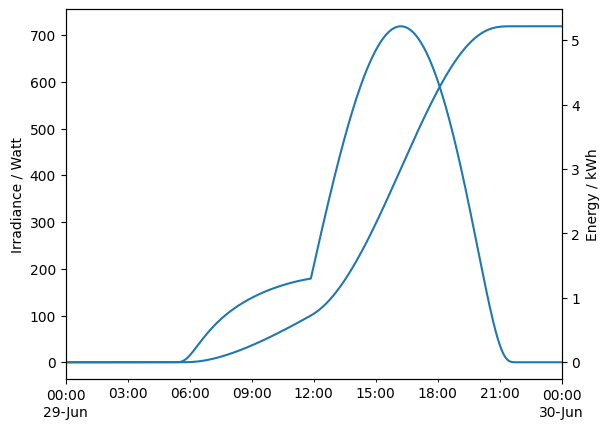

In [74]:
df_combined_opt["south_curve_integrate"] = integrate.cumulative_trapezoid(df_combined_opt["south_curve"], initial=0, dx=60) / 3_600_000
df_combined_opt["south_curve"].plot()
plt.ylabel("Irradiance / Watt")
plt.twinx()
df_combined_opt["south_curve_integrate"].plot()
plt.ylabel("Energy / kWh")

In [84]:
df_combined_opt.index[:2].diff()[-1]

Timedelta('0 days 00:01:00')

# Vectors

Find azimuth from https://osmcompass.com/

$$
\begin{pmatrix}
x\\
y\\
z
\end{pmatrix}
= 
\begin{pmatrix}
\text{Nord}\\
\text{Ost}\\
\text{Himmel}
\end{pmatrix}
$$

In [62]:
pd.date_range('2024-01-01', '2024-01-02', freq="10min")

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 00:10:00',
               '2024-01-01 00:20:00', '2024-01-01 00:30:00',
               '2024-01-01 00:40:00', '2024-01-01 00:50:00',
               '2024-01-01 01:00:00', '2024-01-01 01:10:00',
               '2024-01-01 01:20:00', '2024-01-01 01:30:00',
               ...
               '2024-01-01 22:30:00', '2024-01-01 22:40:00',
               '2024-01-01 22:50:00', '2024-01-01 23:00:00',
               '2024-01-01 23:10:00', '2024-01-01 23:20:00',
               '2024-01-01 23:30:00', '2024-01-01 23:40:00',
               '2024-01-01 23:50:00', '2024-01-02 00:00:00'],
              dtype='datetime64[ns]', length=145, freq='10min')